# Visualising annual variation

In this notebook I'll visualise daily stream gauge measurements (which provide a sort of spatially and temporally averaged rainfall record) from the London Road gauge on Manchester's river Medlock. It's in Longsight and is [station 69020](https://nrfa.ceh.ac.uk/data/station/info/69020) in the UK's National River Flow Archive (NRFA).

In [3]:
# Load the libraries we'll use

# Basic numerics
import numpy as np
import scipy as sp

# Data handling
import pandas as pd

# Date handling
import datetime as dt

# Graphics
import matplotlib.pyplot as plt

If need be, make a directory to store figures.

In [5]:
# https://www.tutorialspoint.com/How-can-I-create-a-directory-if-it-does-not-exist-using-Python
import os
if not os.path.exists('Figures'):
    os.makedirs('Figures')

## Read and check the data

The flow is in cubic meters per second, averaged over the day.

In [8]:
medlock_df = pd.read_csv('StreamGauge_MedlockLondonRoad.csv')
medlock_df.head()

,Date,Flow
0,01/01/1974,0.626
1,02/01/1974,0.549
2,03/01/1974,0.573
3,04/01/1974,0.683
4,05/01/1974,0.977


#### Make a quick survey of the data

In [10]:
medlock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17075 entries, 0 to 17074
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    17075 non-null  object 
 1   Flow    17041 non-null  float64
dtypes: float64(1), object(1)
memory usage: 266.9+ KB


In [11]:
medlock_df.describe()

,Flow
count,17041.000000
mean,0.857496
std,1.032469
min,0.055000
25%,0.326000
50%,0.530000
75%,0.980000
max,20.980000


#### Look at the distribution of values

First, look at the distribution of flow data on both original and log scales.

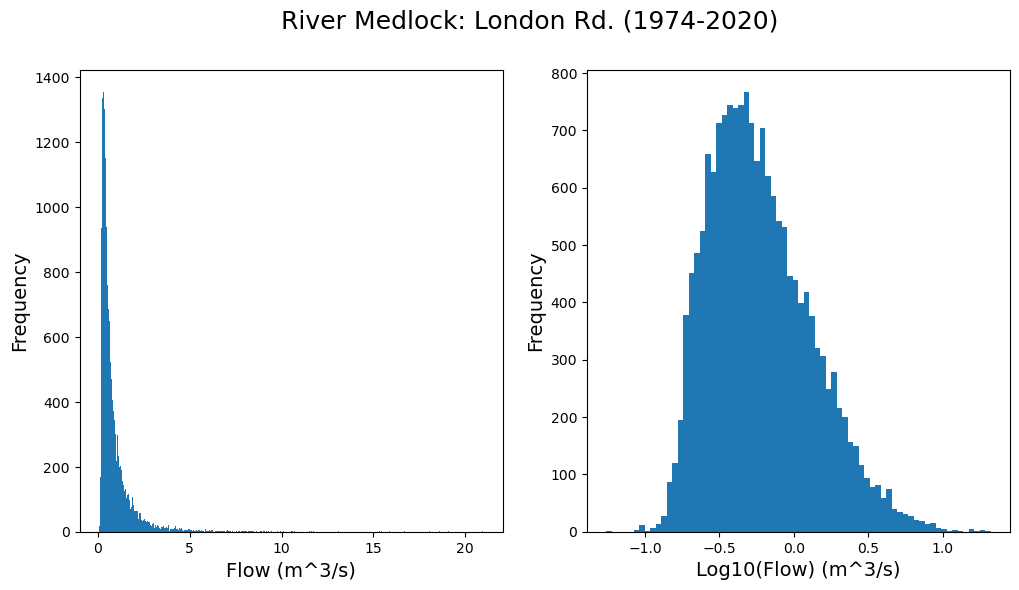

In [14]:
# Set the dimensions of the plot
heightInInches = 6
widthInInches = 12
myFig, myAxes = plt.subplots(1,2, figsize=[widthInInches,heightInInches])

# Get the flow data as a numpy array
flowVals = medlock_df["Flow"].to_numpy()

# Draw the histograms
myAxes[0].hist( flowVals, bins='fd' )
myAxes[0].set_xlabel('Flow (m^3/s)', fontsize=14 )
myAxes[0].set_ylabel('Frequency', fontsize=14 )

myFig.suptitle('River Medlock: London Rd. (1974-2020)', fontsize=18)

myAxes[1].hist( np.log10(flowVals), bins='fd' )
myAxes[1].set_xlabel('Log10(Flow) (m^3/s)', fontsize=14 )
myAxes[1].set_ylabel('Frequency', fontsize=14 )

plt.savefig( "Figures/FlowDistrib.pdf" )
plt.show()

Now we'll plot a time series on a log scale

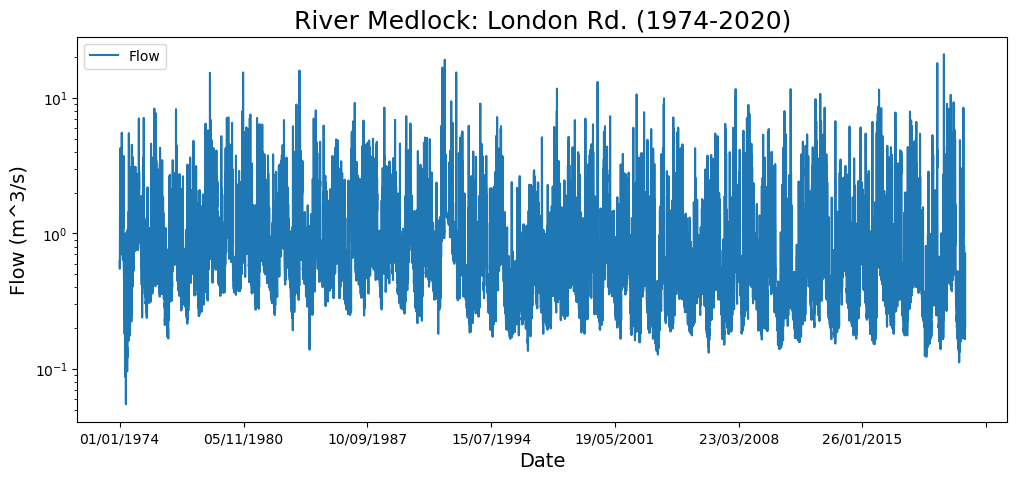

In [16]:
ax = medlock_df.plot( x='Date', y='Flow',
    figsize=(12, 5), kind='line', logy=True )

ax.set_title( 'River Medlock: London Rd. (1974-2020)', fontsize=18 ) 
ax.set_ylabel( 'Flow (m^3/s)', fontsize=14 )
ax.set_xlabel( 'Date', fontsize=14 )
plt.savefig( "Figures/AllFlowData.pdf" )

## Process the data so that we can get get annual traces

Here I add two extra columns to the data frame, one that gives the year and another that gives the day in the year such that 1 Jan. is day 1 and 31 Dec. is day 365 or, in leap years, day 366.

In [19]:
# Define a function that uses built-in Pandas tools 
# to get the year and day-of-year
def getYearAndDoY( dateStr ):
    # Convert the date string to a Timestamp object
    ts = pd.to_datetime( dateStr, dayfirst=True )
    
    # Extract the desired data
    return( [ts.year, ts.day_of_year] )

# Test the function: result should be [1960, 31+16=47]
getYearAndDoY( "16/2/1960" ) 

[1960, 47]

Add columns for the year and day-of-year to the dataframe. My approach is a bit of a faff and there may be more elegant ways to do this.

In [21]:
# Make a list whose entries are [Year, DayOfYear] pairs
list_of_pairs = medlock_df["Date"].apply(getYearAndDoY).to_list()

# Convert the list of pairs into a pair of lists.
# See: https://stackoverflow.com/questions/21444338/transpose-nested-list-in-python
pair_of_lists = np.array( list_of_pairs ).transpose().tolist()

# Add the new columns
medlock_df = medlock_df.assign( Year=pair_of_lists[0], DayOfYear=pair_of_lists[1] )

# Look at the result
medlock_df.tail() # shows bottom 5 rows

,Date,Flow,Year,DayOfYear
17070,26/09/2020,0.214,2020,270
17071,27/09/2020,0.204,2020,271
17072,28/09/2020,0.202,2020,272
17073,29/09/2020,0.203,2020,273
17074,30/09/2020,0.710,2020,274


## Assemble a numpy array, each of whose columns hold a year's worth of data

In leap years we'll just drop the 366th day.

In [24]:
# Work out how many complete years we have
firstYear = 1974
lastYear = 2019 # data for 2020 stops at the end of September
nYears = lastYear - firstYear + 1

# Build the matrix and fill it
annualFlowSeriesMat = np.zeros( (365, nYears) )
for j in range(nYears):
    crntYear = firstYear + j 
    annualFlowSeriesMat[:,j] = medlock_df[(medlock_df["Year"] == crntYear) & (medlock_df["DayOfYear"] < 366)]["Flow"]
    
# Look at the result
annualFlowSeriesMat.shape

(365, 46)

## Various visualisations

The easiest thing to do is overlay many semi-transparent traces

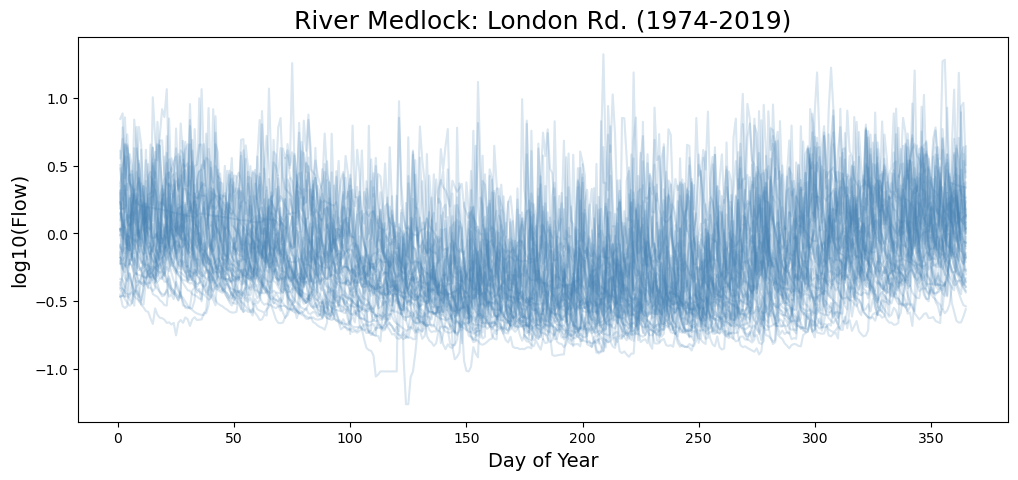

In [27]:
# Get a list of day-numbers
dayOfYear = np.linspace( 1, 365, num=365 )

# Set the size of the figure
plt.figure(figsize=(12,5))

# Plot each column of our data matrix as a separate trace, using a semi-transparent colour
plt.plot( dayOfYear, np.log10(annualFlowSeriesMat), color="steelblue", alpha=0.2 )

# Add labels and display the result
plt.xlabel('Day of Year', fontsize=14 )
plt.ylabel('log10(Flow)', fontsize=14 )
plt.title('River Medlock: London Rd. (1974-2019)', fontsize=18 )
plt.savefig( "Figures/AllAnnualFlowTraces.pdf" )
plt.show()

The next-fanciest thing is to get, for each day, the median and quartiles over the 46 years for which we have data and then plot those. The curves are a bit jaged, as we don't have all that much data for any given day, but they reveal a seasonal trend for drier summers and wetter winters.

In [29]:
# Define a function that computes quartile for a row, skipping NaN's
def getQuartiles( row ):
    return( np.nanquantile( row, [0.25, 0.5, 0.75] ) ) 

# Get a matrix whose columns are series of quartiles-per-day
quartileMat = np.apply_along_axis( getQuartiles, axis=1, arr=np.log10(annualFlowSeriesMat) ) # result will have quantile curves as columns
quartileMat.shape

(365, 3)

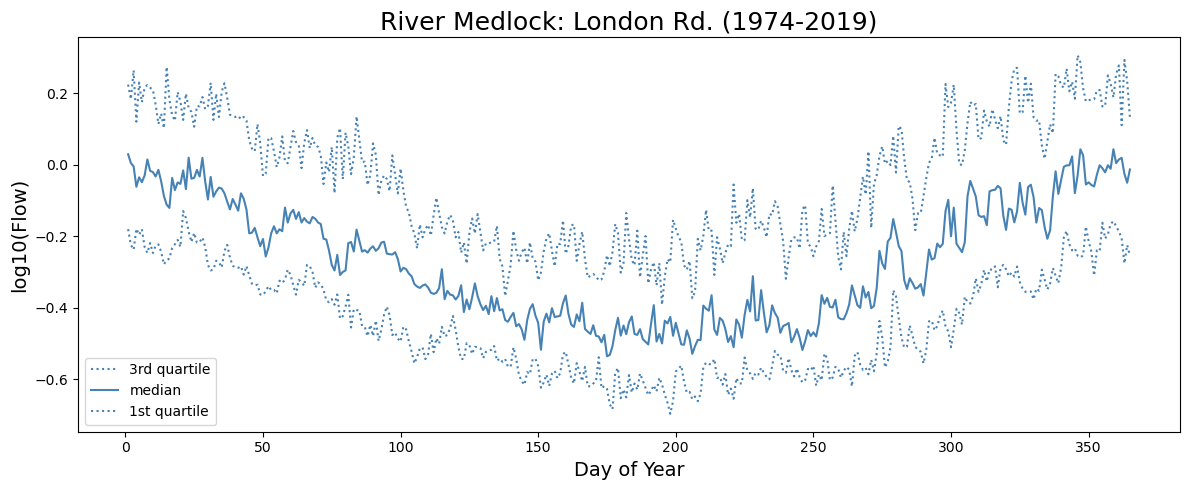

In [30]:
# Set the size of the figure
plt.figure(figsize=(12,5))

# Plot the 1st quartile, median and 3rd quartile for each day
plt.plot( dayOfYear, quartileMat[:,2], color="steelblue", linestyle="dotted", label="3rd quartile" )
plt.plot( dayOfYear, quartileMat[:,1], color="steelblue", label="median" )
plt.plot( dayOfYear, quartileMat[:,0], color="steelblue", linestyle="dotted", label="1st quartile" )

# Add labels and display the result
plt.xlabel('Day of Year', fontsize=14 )
plt.ylabel('log10(Flow)', fontsize=14)
plt.title('River Medlock: London Rd. (1974-2019)', fontsize=18 )

plt.legend()
plt.tight_layout()
plt.savefig( "Figures/AnnualFlowWithQuartiles.pdf" )
plt.show()

Finally, plot a heatmap. We begin by using numpy's `histogram_bin_edges()` function to choose bin-boundaries for the whole dataset

In [32]:
# Choose bin boundaries
nBins = 20
nan_free_df = medlock_df.dropna()
nan_free_data = nan_free_df["Flow"].to_numpy()
bin_boundaries = np.histogram_bin_edges( np.log10(nan_free_data), bins=nBins )
bin_boundaries

array([-1.25963731, -1.13056517, -1.00149303, -0.87242089, -0.74334875,
       -0.61427661, -0.48520447, -0.35613233, -0.22706019, -0.09798805,
        0.03108409,  0.16015623,  0.28922837,  0.41830051,  0.54737265,
        0.67644479,  0.80551692,  0.93458906,  1.0636612 ,  1.19273334,
        1.32180548])

In [33]:
# Make a matrix whose columns are per-day-histograms
def dayHistogram( row, bb ):
    # Get rid of NaN's
    data = row[np.logical_not(np.isnan(row))]
    if( len(data) > 0 ):
        density, bin_edges = np.histogram( row, bins=bb, density=True )
    else:
        density = np.zeros(len(bb) - 1) 
        
    return( density ) 

# Get a matrix whose columns are series of quartiles-per-day
densityMat = np.apply_along_axis( dayHistogram, axis=1, arr=np.log10(annualFlowSeriesMat), bb=bin_boundaries )
densityMat.shape

(365, 20)

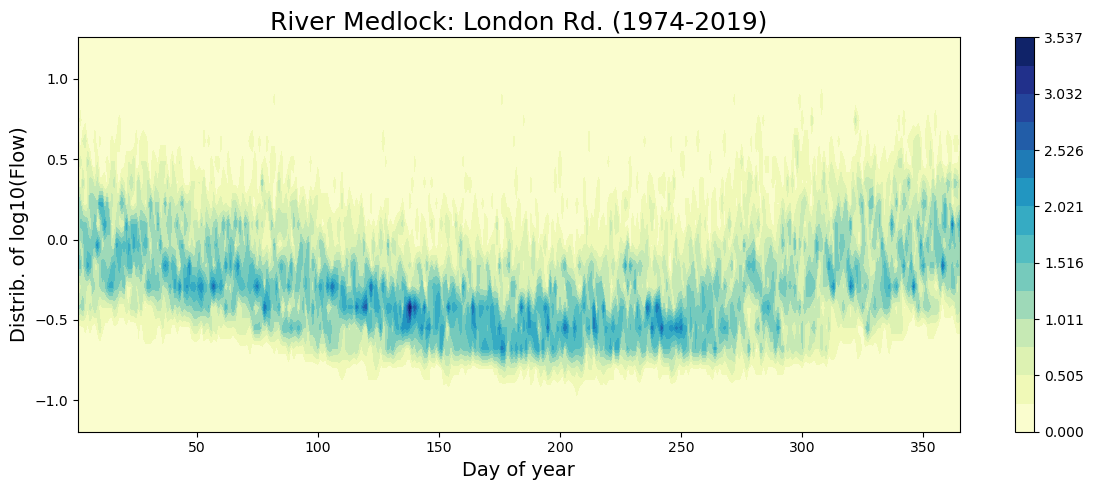

In [34]:
nLevels = 15
densityLevels = np.linspace( start=0, stop=np.max(densityMat), num=nLevels )
binMidPoints = 0.5 * (bin_boundaries[1:(nBins+1)] + bin_boundaries[0:nBins])
colorMap = plt.get_cmap('YlGnBu')
heatmapFig = plt.figure(figsize=[12,5])
contourMap = plt.contourf(dayOfYear, binMidPoints, densityMat.transpose(), levels=densityLevels, cmap=colorMap )
plt.xlabel('Day of year', fontsize=14)
plt.ylabel('Distrib. of log10(Flow)', fontsize=14)
plt.title('River Medlock: London Rd. (1974-2019)', fontsize=18)
cbar = plt.colorbar(contourMap)

plt.tight_layout()
plt.savefig( "Figures/AnnualFlowHeatmap.pdf" )

The colored strip above a day's number shows the distribution of $\log_{10}()$ flow data for that day.